In [110]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from  sklearn.ensemble import RandomForestRegressor

In [111]:
# load data
descriptions = pd.read_excel('DatiProject.xlsx', sheet_name=3)
raw_standard_vars = pd.read_excel('DatiProject.xlsx', sheet_name=0)

In [112]:
# create new columns for needed transformed variables
raw_standard_vars['log_gdp'] = np.log(raw_standard_vars['GDPC1'])
raw_standard_vars['log_cpi'] = np.log(raw_standard_vars['PCECTPI'])
raw_standard_vars['inflation'] = raw_standard_vars['log_cpi'].diff().fillna(0)
raw_standard_vars['tspread'] = raw_standard_vars['GS10'] - raw_standard_vars['TB3MS']
raw_standard_vars['diff_log_gdp'] = raw_standard_vars['log_gdp'].diff().fillna(0)

## Section 1

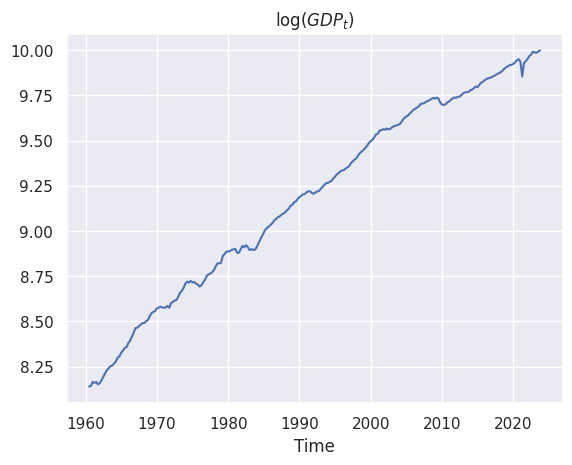

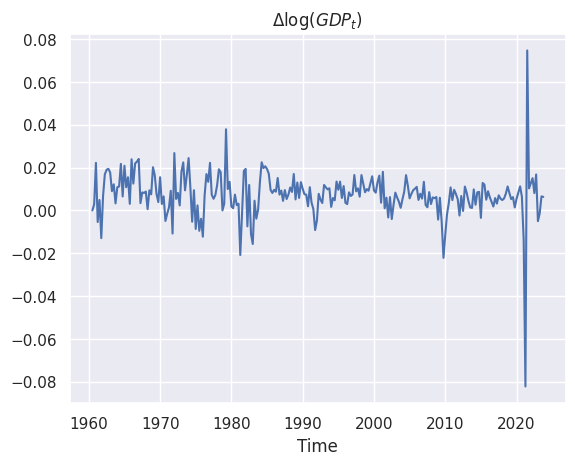

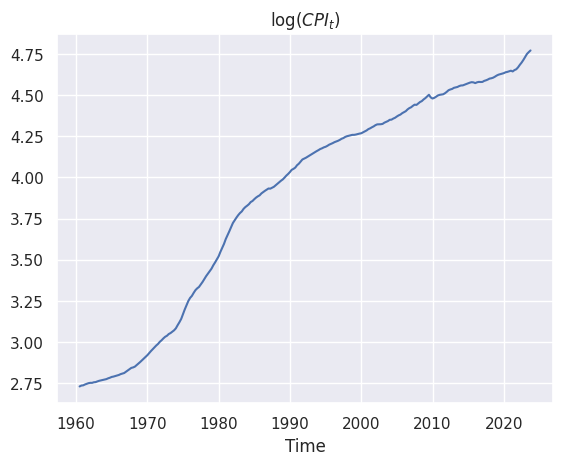

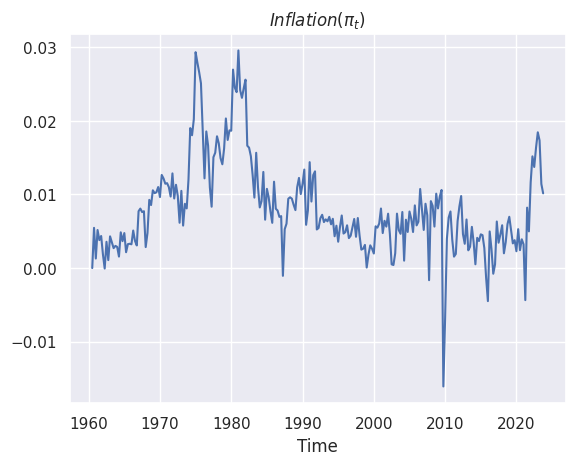

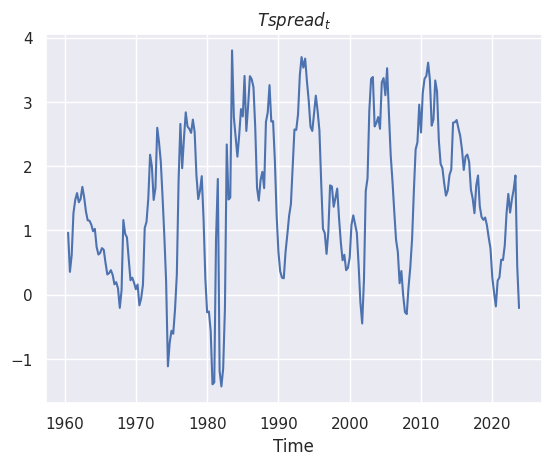

In [113]:
vars_1 = ['log_gdp', 'diff_log_gdp', 'log_cpi', 'inflation', 'tspread']
titles_vars_1 = [r'$\log(GDP_t)$', r'$\Delta \log(GDP_t)$', r'$\log(CPI_t)$', r'$Inflation(\pi_t)$', r'$T spread_t$']

def plot_series(data, vars, titles):
    for v, title in zip(vars, titles):
        sns.set_theme()
        sns.lineplot(data=data, y=v, x='Time')
        plt.title(title)
        plt.ylabel('')
        plt.show()

plot_series(raw_standard_vars, vars_1, titles_vars_1)

## Section 2

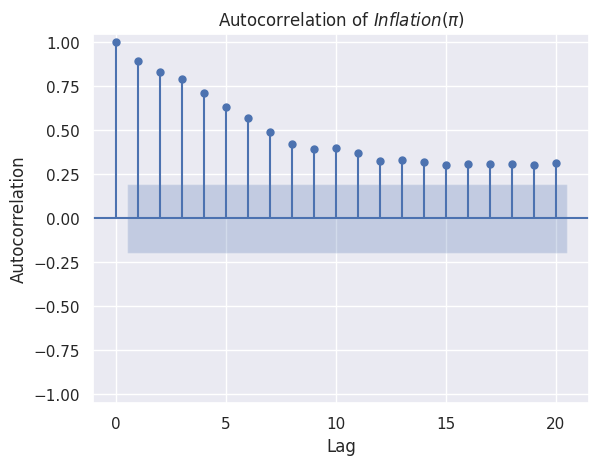

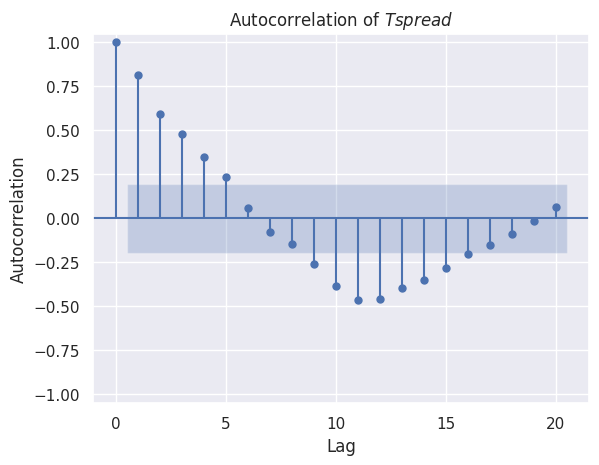

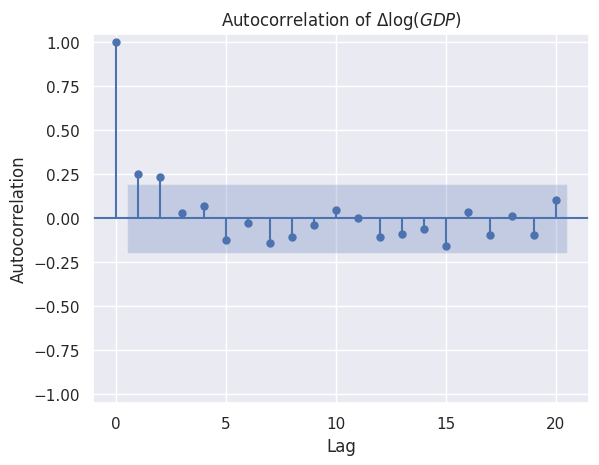

In [114]:
sample_1 = raw_standard_vars[(raw_standard_vars['Time'] < '1985-07-01') & (raw_standard_vars['Time'] > '1960-07-10')].reset_index(drop=True)

columns_autocorr = ['inflation', 'tspread', 'diff_log_gdp']
titles_autocorr = [ r'$Inflation(\pi)$', r'$T spread$', r'$\Delta \log(GDP)$' ]

for column, title in zip(columns_autocorr, titles_autocorr):
    ts = sample_1[column]
    plot_acf(ts, bartlett_confint=False)
    plt.title(f'Autocorrelation of {title}')
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.ylim([-1.05, 1.05])
    plt.show()

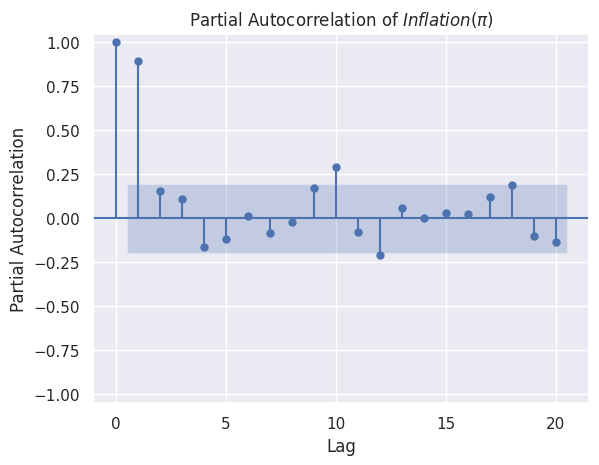

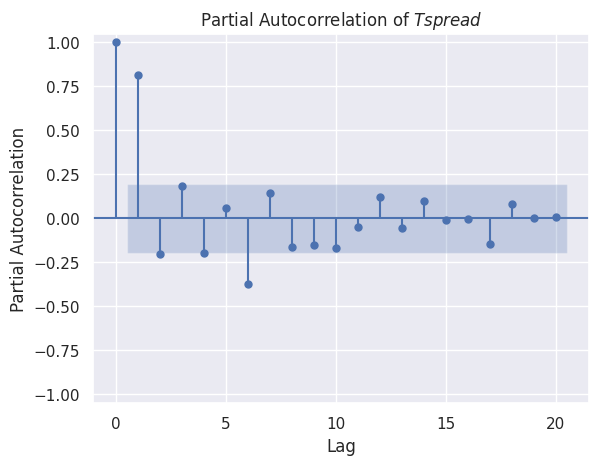

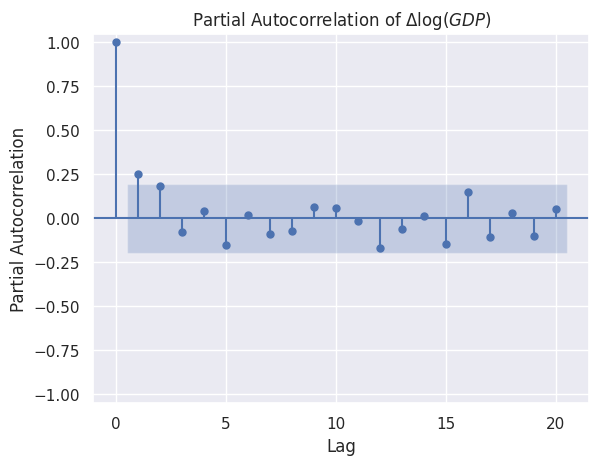

In [115]:
columns_autocorr = ['inflation', 'tspread', 'diff_log_gdp']
titles_autocorr = [ r'$Inflation(\pi)$', r'$T spread$', r'$\Delta \log(GDP)$' ]

for column, title in zip(columns_autocorr, titles_autocorr):
    ts = sample_1[column]
    plot_pacf(ts)
    plt.title(f'Partial Autocorrelation of {title}')
    plt.xlabel("Lag")
    plt.ylabel("Partial Autocorrelation")
    plt.ylim([-1.05, 1.05])
    plt.show()

Find p for Var(p) models through AIC

In [116]:
model_vars = sample_1[['diff_log_gdp', 'inflation', 'tspread']]
ps = range(1, 25)
aics = []
for p in ps:
    # Create VAR model
    model = VAR(model_vars)
    # Fit the model with the chosen lag order
    results = model.fit(p)
    aics.append(abs(results.aic))

i = np.argmin(aics)
p_min = i + 1
aic_min = aics[i]

print(p_min, aic_min)

1 21.52242321928951


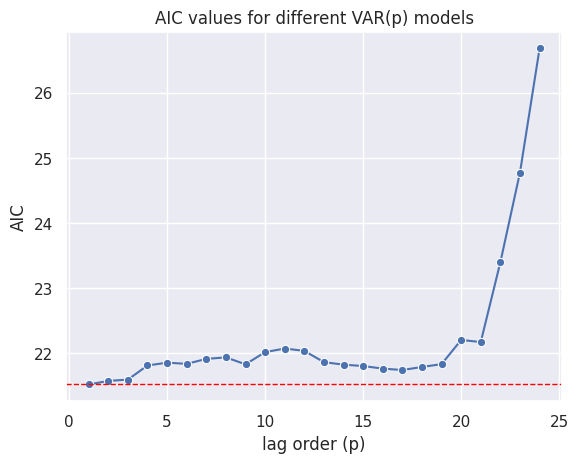

In [117]:
sns.lineplot(y=aics, x=list(ps), marker='o')
plt.xlabel('lag order (p)')
plt.ylabel('AIC')
plt.title('AIC values for different VAR(p) models')
plt.axhline(aic_min, color='red', linestyle='--', linewidth=1)

In [118]:
var1 = VAR(model_vars)
results_var1 = model.fit(1)
results_var1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 14, Dec, 2023
Time:                     01:28:45
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -21.2079
Nobs:                     99.0000    HQIC:                  -21.3952
Log likelihood:           655.935    FPE:                4.49767e-10
AIC:                     -21.5224    Det(Omega_mle):     3.99376e-10
--------------------------------------------------------------------
Results for equation diff_log_gdp
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.009531         0.002572            3.706           0.000
L1.diff_log_gdp         0.133974         0.096090            1.394           0.163
L1.inflation           -0.362962         0.14

In [119]:
residuals_var1 = results_var1.resid
residuals_var1['Time'] = sample_1['Time']
residuals_var1.head()

,diff_log_gdp,inflation,tspread,Time
1,0.013502,-0.004896,0.016308,1960-12-30
2,-0.018838,0.002211,0.620706,1961-03-30
3,-0.004936,-0.001555,0.031433,1961-06-30
4,-0.025086,-0.000002,0.061602,1961-09-30
5,-0.003099,-0.002430,-0.348396,1961-12-30


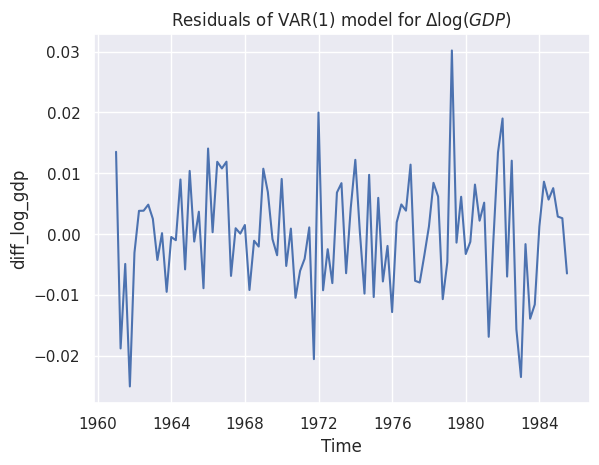

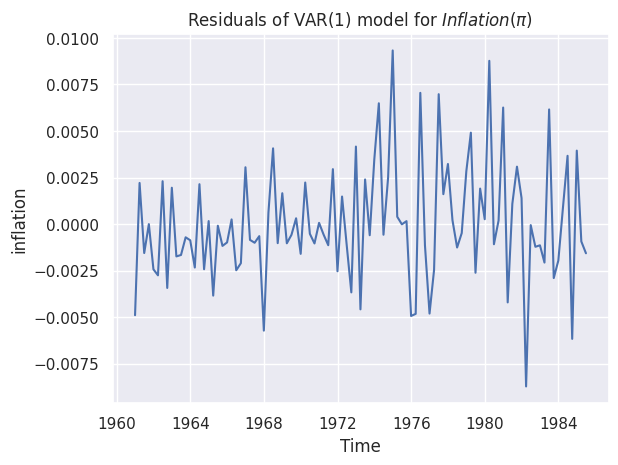

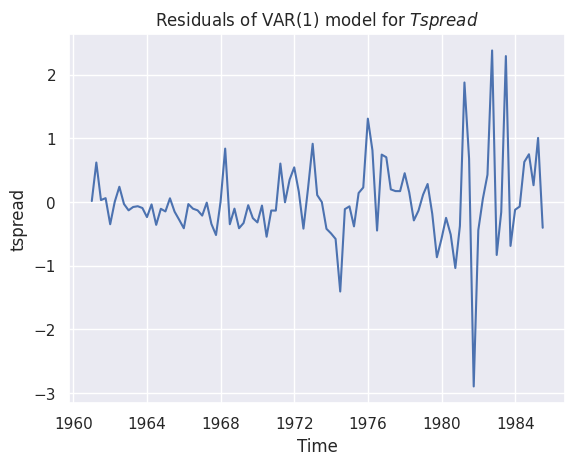

In [120]:
residuals_col = ['diff_log_gdp', 'inflation', 'tspread']
residuals_titles = [r'$\Delta \log(GDP)$', r'$Inflation(\pi)$', r'$T spread$' ]
for residual, title in zip(residuals_col, residuals_titles):
    sns.lineplot(data=residuals_var1, y=residual, x = 'Time')
    plt.title(f'Residuals of VAR(1) model for {title}')
    plt.show()

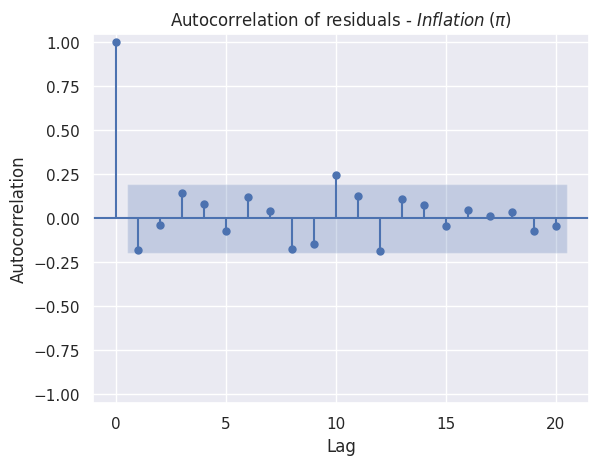

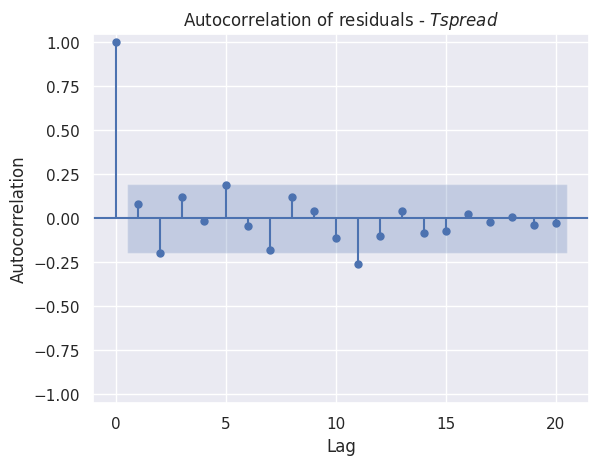

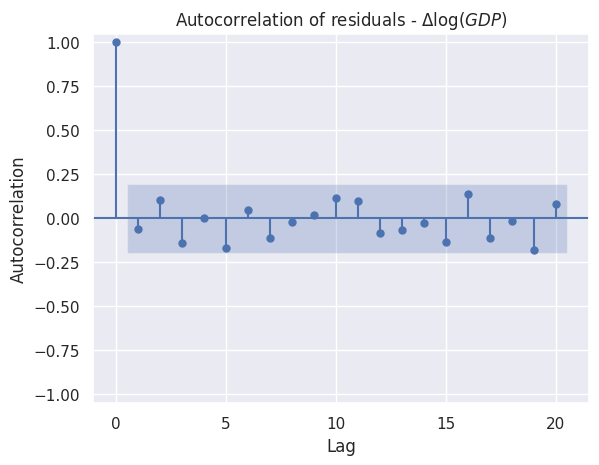

In [121]:
col_res_parcorr = ['inflation', 'tspread', 'diff_log_gdp', ]
titles_res_parcorr = [ r'$Inflation\:(\pi)$', r'$T spread$', r'$\Delta \log(GDP)$' ]

for column, title in zip(col_res_parcorr, titles_res_parcorr):
    ts = residuals_var1[column]
    plot_acf(ts, bartlett_confint=False)
    plt.title(f'Autocorrelation of residuals - {title}')
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.ylim([-1.05, 1.05])
    plt.show()

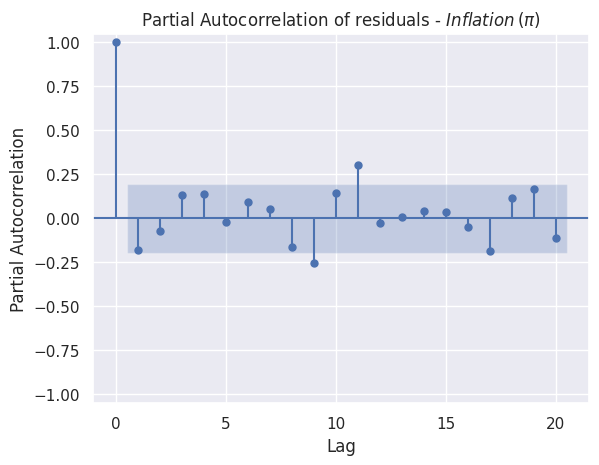

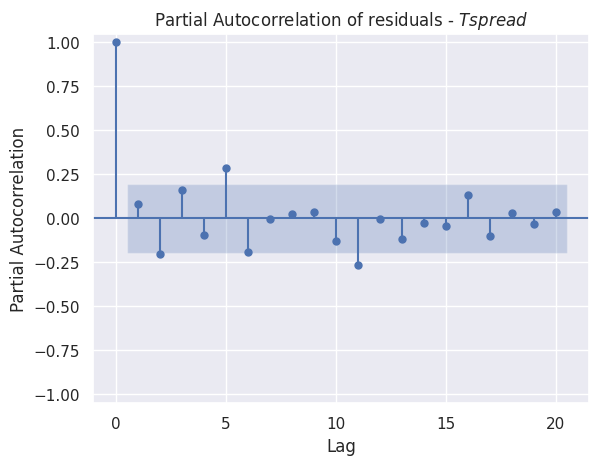

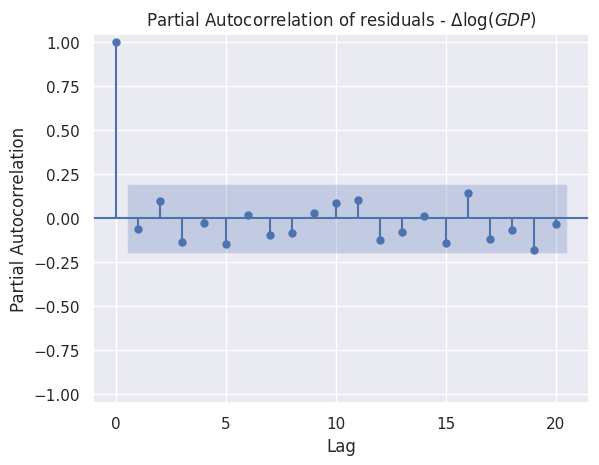

In [122]:
col_res_parcorr = ['inflation', 'tspread', 'diff_log_gdp', ]
titles_res_parcorr = [ r'$Inflation\:(\pi)$', r'$T spread$', r'$\Delta \log(GDP)$' ]

for column, title in zip(col_res_parcorr, titles_res_parcorr):
    ts = residuals_var1[column]
    plot_pacf(ts)
    plt.title(f'Partial Autocorrelation of residuals - {title}')
    plt.xlabel("Lag")
    plt.ylabel("Partial Autocorrelation")
    plt.ylim([-1.05, 1.05])
    plt.show()

## Section 3

In [123]:
raw_factors = pd.read_excel('DatiProject.xlsx', sheet_name=1)
sample_1_factors_with_time = raw_factors[(raw_factors['Time'] < '1985-07-01') & (raw_factors['Time'] > '1960-07-10')].reset_index(drop=True)
sample_1_factors = sample_1_factors_with_time.drop(['Time'], axis=1)
sample_1_factors =(sample_1_factors-sample_1_factors.mean())/sample_1_factors.std()
sample_1_factors = pd.concat([sample_1_factors_with_time["Time"], sample_1_factors], axis=1).reset_index(drop=True)

In [124]:
np.set_printoptions(suppress=True)
pca = PCA(n_components=10)
pccomps = pca.fit_transform(sample_1_factors.drop('Time', axis=1))

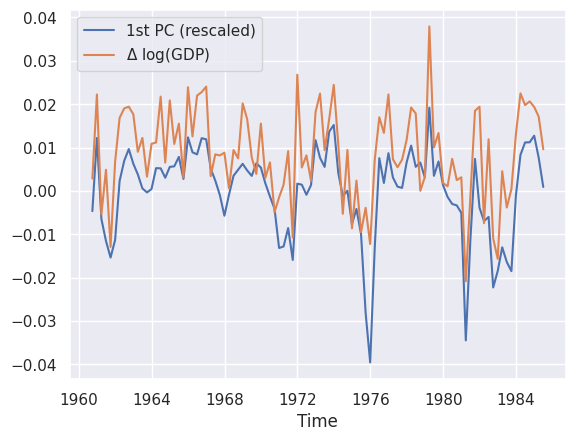

In [125]:
pc_1 = [p[0] for p in pccomps]

gdp_sample = sample_1['diff_log_gdp']
pc_1_scaled = [-((max(gdp_sample) - min(gdp_sample)) / (max(pc_1) - min(pc_1)) )  * x for x in pc_1]


sns.lineplot(y=pc_1_scaled, x=sample_1['Time'], label='1st PC (rescaled)')
sns.lineplot(y=gdp_sample, x=sample_1['Time'], label='$\Delta$ log(GDP)')
plt.ylabel('')
plt.legend()

[[0.9376107963163012, 'USGOOD'], [0.9327991907531371, 'OUTMS'], [0.9235587166096606, 'MANEMP'], [0.9232137738303302, 'USPRIV'], [0.9199523226897185, 'INDPRO'], [0.9154257393397538, 'UNRATE'], [0.9139851779160268, 'PAYEMS'], [0.9131629034382072, 'IPMANSICS'], [0.9095409790343172, 'LNS14000025'], [0.9067141266681102, 'DMANEMP'], [0.8784922660223092, 'LNS13023621'], [0.878384450807323, 'UNRATESTx'], [0.8780296615182934, 'IPFINAL'], [0.8757255766416756, 'HOANBS'], [0.860174352959962, 'EXUSEU'], [0.8548863299539713, 'CMRMTSPLx'], [0.8508548249470808, 'IPMAT'], [0.8488541102197553, 'IPBUSEQ'], [0.8406904548763453, 'NDMANEMP'], [0.8404312476326967, 'HOAMS'], [0.835456233661941, 'FPIx'], [0.8347015716201944, 'Y033RC1Q027SBEAx'], [0.8316825529496481, 'HOABS'], [0.8305034371048202, 'PNFIx'], [0.8261650688560017, 'HWIURATIOx'], [0.8183115054235804, 'USTPU'], [0.8174176478376914, 'IPDMAT'], [0.8154621293406518, 'LNS14000026'], [0.8145618134201432, 'SPCS10RSA'], [0.8074451916823074, 'OUTNFB']]


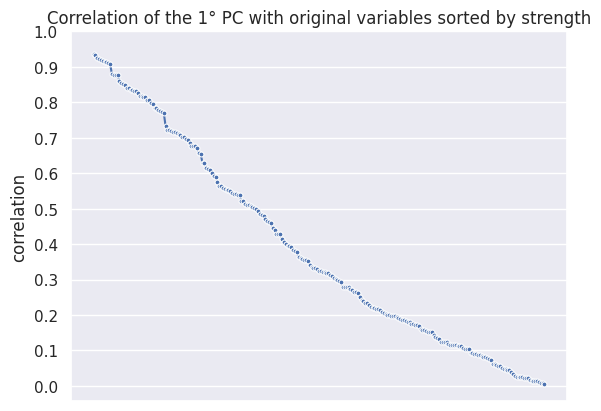

In [202]:
from numpy import cov
from scipy.stats import pearsonr

tt = []
for x in [x for x in sample_1_factors.columns if x != "Time"]:
    s = pearsonr([x[0] for x in pccomps], sample_1_factors[x])
    tt.append([abs(s.statistic), x])

tt = sorted(tt, reverse=True)

sns.lineplot(y = [t[0] for t in tt], x = list(range(1, 246)), marker="o", markersize=3.5)
plt.title("Correlation of the 1° PC with t original variables sorted by strength")
plt.ylabel("correlation")
plt.xlabel("")
plt.xticks([])
plt.yticks([0.1*x for x in range(11)])
print(tt[:30])

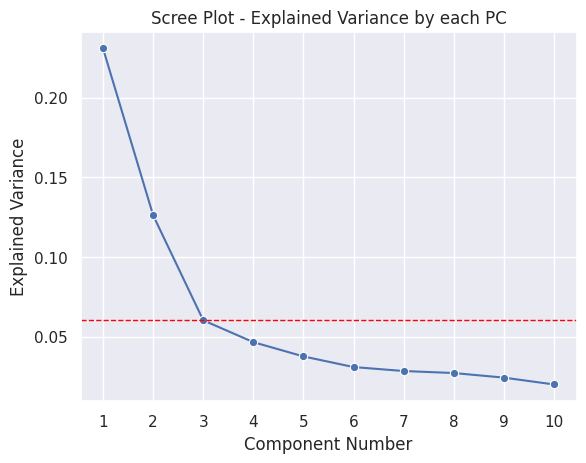

In [127]:
sns.lineplot(y = pca.explained_variance_ratio_, x = list(range(1,11)), marker="o")
plt.xticks([x for x in range(1, 11)])
plt.title("Scree Plot - Explained Variance by each PC")
plt.xlabel("Component Number")
plt.ylabel("Explained Variance")
plt.axhline(pca.explained_variance_ratio_[2], color='red', linestyle='--', linewidth=1)

In [128]:
# most important factors for first principal component
factor_importance_df = pd.DataFrame({
    'ID': list(range(1,246)),
    'Loading': abs(pca.components_[0])
})

factor_importance_df = factor_importance_df.sort_values('Loading', ascending=False)
factor_importance_df = factor_importance_df.set_index('ID').join(descriptions.set_index('ID'))

factor_importance_df.head(50)

# TODO: Actually he asks us to plot it

,Loading,SW ID,TCODE,SW Factors,FRED MNEMONIC,SW MNEMONIC,DESCRIPTION,Group
ID,,,,,,,,
38,0.124695,38,5.0,0.0,SRVPRD,Emp:Services,All Employees: Service-Providing Industries (T...,3.0
20,0.124055,20,5.0,0.0,OUTBS,Output:Bus,Business Sector: Real Output (Index 2009=100),1.0
36,0.122826,36,5.0,0.0,USPRIV,Emp:Private,All Employees: Total Private Industries (Thous...,3.0
35,0.122780,35,5.0,0.0,PAYEMS,Emp:Nonfarm,All Employees: Total nonfarm (Thousands of Per...,3.0
21,0.122346,21,5.0,0.0,OUTMS,Output:Manuf,Manufacturing Sector: Real Output (Index 2009=...,1.0
58,0.121744,58,2.0,0.0,CIVPART,LF Part Rate,Civilian Labor Force Participation Rate (Percent),3.0
34,0.121553,34,1.0,1.0,CUMFNS,Capu Man.,Capacity Utilization: Manufacturing (SIC) (Per...,2.0
191,0.121443,n.a.,2.0,0.0,B021RE1Q156NBEA,NaN,Shares of gross domestic product: Imports of g...,1.0
62,0.120962,62,2.0,1.0,LNS14000012,Urate:Age16-19,Unemployment Rate - 16 to 19 years (Percent),3.0


## Section 4

In [129]:
def RandomWalk(y):
    return ARIMA(y, order=(0,0,0)).fit(method='yule_walker')
def AutoRegressive(p, q, y):
    return ARIMA(y, order=(p,0,q)).fit(method='yule_walker')
def AutoRegressiveWithPC(p, q, y, pc):
    return ARIMA(y, order=(p,0,q), exog=pc).fit(method='yule_walker')
def VectorAutoregression(p, vars):
    return VAR(vars).fit(p)
def Standardize_Sample(sample):
    return (sample-sample.mean())/sample.std()
def Run_InSample_PCA(sample, n_pc):
    return [p for p in PCA(n_components=n_pc).fit_transform(sample)]

raw_factors_notime = raw_factors.drop(['Time'], axis=1)
windows_size = 100
raw_standard_vars_till2019 = raw_standard_vars[(raw_standard_vars['Time'] < '2019-01-01') & (raw_factors['Time'] > '1960-07-01')].reset_index(drop=True)

forecasts = []
for i in range(len(raw_standard_vars_till2019)-windows_size):
    # calculate insample first principal component
    sample_factors = raw_factors_notime[i:101+i]
    sample_factors = Standardize_Sample(sample_factors)
    pc = Run_InSample_PCA(sample_factors, 1)
    pcs = Run_InSample_PCA(sample_factors, 2)
    # create rolling windows
    arima_data = raw_standard_vars_till2019["diff_log_gdp"][i:100+i]
    var_data = raw_standard_vars_till2019[['diff_log_gdp', 'inflation', 'tspread']][i:100+i]
    # estimate models
    RW = RandomWalk(arima_data)
    AR4 = AutoRegressive(4, 0, arima_data)
    VAR4 = VectorAutoregression(4, var_data)
    VAR1 = VectorAutoregression(1, var_data)
    AR4X = AutoRegressiveWithPC(4, 0, arima_data, pc[:-1])

    forecasts.append([0, float(AR4.forecast().iloc[0]), float(VAR4.forecast(var_data.values[-4:], 1)[0][0]), 
                      float(VAR1.forecast(var_data.values[-1:], 1)[0][0]), float(AR4X.forecast(exog=pc[-1]).iloc[0])])

In [130]:
def create_dataframe_models(forecasts, columns):
    a = pd.DataFrame(forecasts, columns=columns)
    a = pd.concat([a, raw_standard_vars_till2019["diff_log_gdp"][100:].reset_index(drop=True)], axis=1)
    a['Time'] = raw_standard_vars_till2019['Time'][100:].reset_index(drop=True)
    for c in columns + ['diff_log_gdp']:
        a[c + '_level'] = np.exp(raw_standard_vars_till2019['log_gdp'][99:].reset_index(drop=True) + a[c])
    a.rename(columns = {'diff_log_gdp_level': 'GDP_level'}, inplace=True)
    return a

In [131]:
a = create_dataframe_models(forecasts, ['RW', 'AR4', 'VAR4', 'VAR1', 'AR4X'])
a

,RW,AR4,VAR4,VAR1,AR4X,diff_log_gdp,Time,RW_level,AR4_level,VAR4_level,VAR1_level,AR4X_level,GDP_level
0,0,0.010184,0.021683,0.013837,0.009174,0.008174,1985-09-30,8252.465,8336.935157,8433.358445,8367.448788,8328.525302,8320.199
1,0,0.008512,0.013663,0.014834,0.008679,0.009643,1985-12-30,8320.199,8391.326850,8434.661812,8444.538859,8392.725262,8400.820
2,0,0.008974,0.018096,0.013858,0.009285,0.008766,1986-03-30,8400.820,8476.551721,8554.226873,8518.049895,8479.180972,8474.787
3,0,0.008979,0.018861,0.014806,0.008750,0.015157,1986-06-30,8474.787,8551.228314,8636.147793,8601.201109,8549.271013,8604.220
4,0,0.010299,0.018586,0.015996,0.008853,0.007407,1986-09-30,8604.220,8693.296104,8765.636300,8742.957904,8680.728053,8668.188
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0,0.006392,0.008023,0.006058,0.006746,0.004857,2017-12-30,19304.352,19428.145356,19459.862236,19421.652296,19435.027544,19398.343
130,0,0.005709,0.004499,0.005698,0.007203,0.005583,2018-03-30,19398.343,19509.414412,19485.822365,19509.194018,19538.583004,19506.949
131,0,0.005830,0.004573,0.006218,0.007426,0.007854,2018-06-30,19506.949,19621.009654,19596.360262,19628.615263,19652.346839,19660.766
132,0,0.006595,0.007398,0.007036,0.006397,0.011207,2018-09-30,19660.766,19790.854632,19806.757055,19799.583680,19786.944211,19882.352


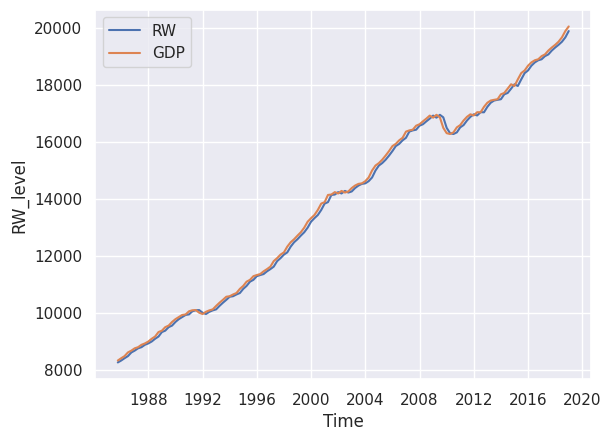

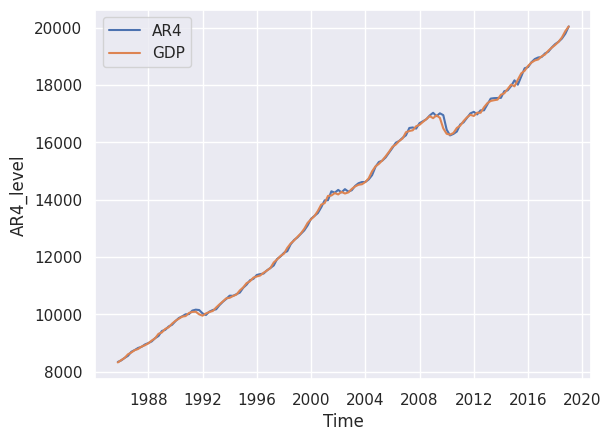

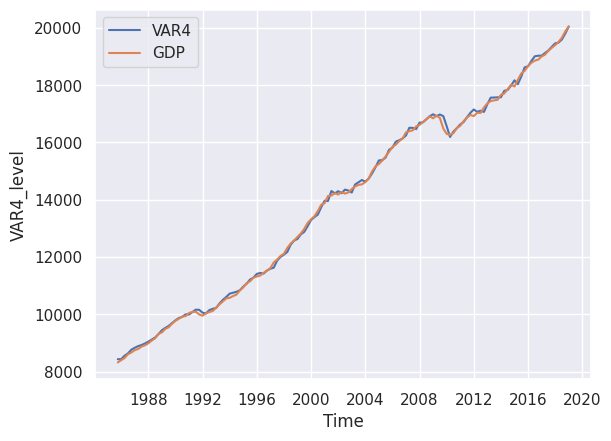

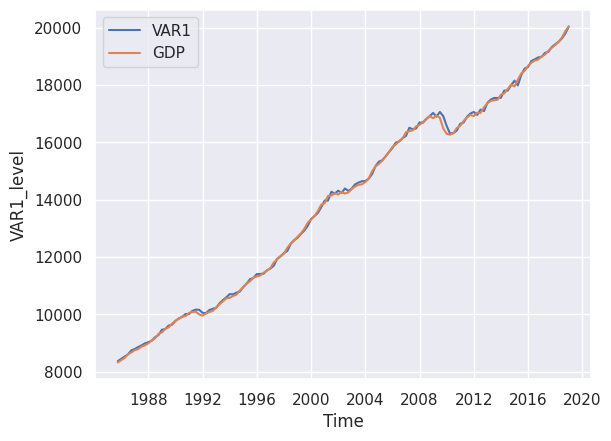

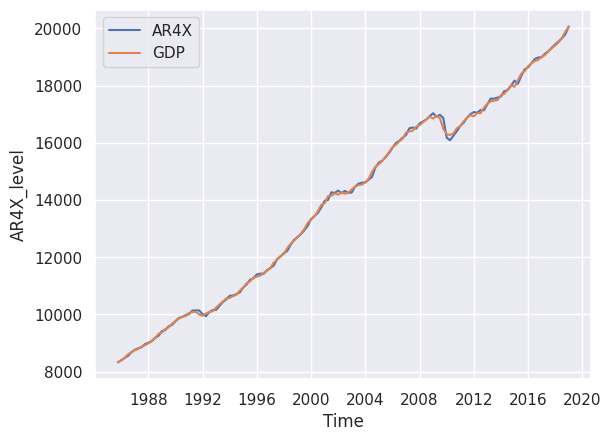

In [132]:
for c in ['RW', 'AR4', 'VAR4', 'VAR1', 'AR4X']:
    sns.lineplot(data=a, x='Time', y=f'{c}_level', label=c)
    sns.lineplot(data=a, x='Time', y='GDP_level', label='GDP')
    plt.legend()
    plt.show()

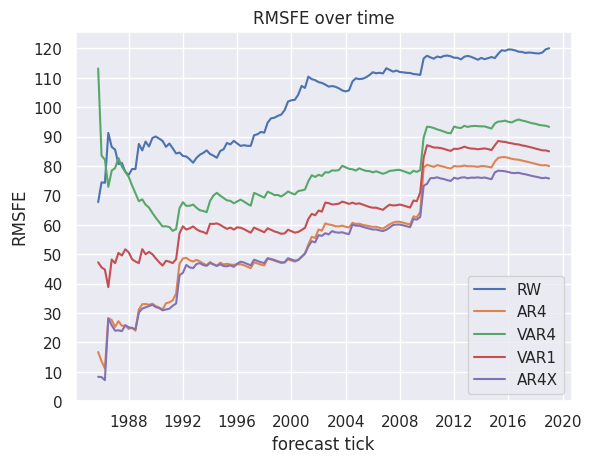

In [133]:
def rmsfe_over_time(a, columns):

    rmse_over_time = []
    
    for i in range(1, len(a["GDP_level"])+1):
        rmse_t = []
        for c in columns:
            v = np.sqrt(sum((a["GDP_level"][:i] - a[c + '_level'][:i])**2)/len(a["GDP_level"][:i]))
            rmse_t.append(v)
        rmse_over_time.append(rmse_t)
    print()
    
    b = pd.DataFrame(rmse_over_time, columns=[f'rmse_{c}' for c in columns])
    
    for c in columns:
        sns.lineplot(data=b, x=a["Time"], y=f'rmse_{c}', label=c)
        plt.legend()
    plt.yticks(range(0,121,10))
    plt.ylabel("RMSFE")
    plt.xlabel("forecast tick")
    plt.title("RMSFE over time")

    return b

b = rmsfe_over_time(a, ['RW', 'AR4', 'VAR4', 'VAR1', 'AR4X'])
plt.show()

In [134]:
b[-1:]

,rmse_RW,rmse_AR4,rmse_VAR4,rmse_VAR1,rmse_AR4X
133,120.059798,80.004779,93.345331,84.99347,75.766591


In [135]:
def AutoRegressive(p, q, y):
    return ARIMA(y, order=(p,0,q)).fit()
def AutoRegressiveWithPC(p, q, y, pc):
    return ARIMA(y, order=(p,0,q), exog=pc).fit()

# custom model

# grid search for a ARIMA with PCs - forward chaining cross validation

def grid_search():
    range_pcs = range(4,5)
    range_p = range(6)
    range_q = range(6)
    params_search = itertools.product(range_pcs, range_p, range_q)
    
    rmse_models = []
    for params_tpl in params_search:
        npcs, p, q = params_tpl
        
        forecasts_custom = []
        for i in range(len(raw_standard_vars_till2019)-windows_size):
            # calculate insample first principal component
            sample_factors = raw_factors_notime[i:101+i]
            sample_factors = Standardize_Sample(sample_factors)
            pcs = Run_InSample_PCA(sample_factors, npcs)
            arima_data = raw_standard_vars_till2019["diff_log_gdp"][i:100+i]
            if pcs:
                AR4_attempt = AutoRegressiveWithPC(p, q, arima_data, pcs[:-1])
                forecasts_custom.append(float(AR4_attempt.forecast(exog=pcs[-1]).iloc[0]))
            else:
                AR4_attempt = AutoRegressive(p, q, arima_data)
                forecasts_custom.append(float(AR4_attempt.forecast().iloc[0]))
        forecasts_custom = np.array(forecasts_custom)
        forecasts_custom = np.exp(raw_standard_vars_till2019['log_gdp'][99:-1].reset_index(drop=True) + forecasts_custom)
        rmse = np.sqrt(sum((a["GDP_level"] - forecasts_custom)**2)/len(a["GDP_level"]))
        rmse_models.append([params_tpl, rmse])
        for x in rmse_models: print(x)

# grid_search()

# best seems ARIMA(1,0,0) with 2 PCs...sob...

In [136]:
def AutoRegressiveWithPC(p, q, y, pc):
    return ARIMA(y, order=(p,0,q), exog=pc).fit(method='yule_walker')

raw_factors_notime = raw_factors.drop(['Time'], axis=1)
windows_size = 100
raw_standard_vars_till2019 = raw_standard_vars[(raw_standard_vars['Time'] < '2019-01-01') & (raw_factors['Time'] > '1960-07-01')].reset_index(drop=True)

forecasts_custom = []  

for i in range(len(raw_standard_vars_till2019)-windows_size):
    # calculate insample first principal component
    sample_factors = raw_factors_notime[i:101+i]
    sample_factors = Standardize_Sample(sample_factors)
    pcs = Run_InSample_PCA(sample_factors, 2)
    # create rolling windows
    arima_data = raw_standard_vars_till2019["diff_log_gdp"][i:100+i]
    # estimate models

    AR1XY = AutoRegressiveWithPC(1, 0, arima_data, pcs[:-1])

    forecasts_custom.append(float(AR1XY.forecast(exog=pcs[-1]).iloc[0]))

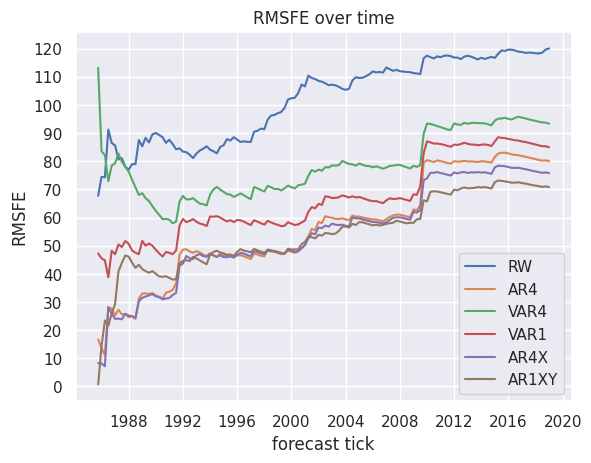

In [138]:
if len(forecasts[0]) > 5:
    for i in range(len(forecasts)):
        forecasts[i][5] = forecasts_custom[i]
else:
    forecasts = [x+[y] for (x,y) in zip(forecasts, forecasts_custom)]

a = create_dataframe_models(forecasts, ['RW', 'AR4', 'VAR4', 'VAR1', 'AR4X', 'AR1XY'])
b = rmsfe_over_time(a, ['RW', 'AR4', 'VAR4', 'VAR1', 'AR4X', 'AR1XY'])

plt.show()

In [139]:
b[-1:]

,rmse_RW,rmse_AR4,rmse_VAR4,rmse_VAR1,rmse_AR4X,rmse_AR1XY
133,120.059798,80.004779,93.345331,84.99347,75.766591,70.825912


In [141]:
raw_factors_notime = raw_factors.drop(['Time'], axis=1)


for s in range(1,5):
    raw_standard_vars_till2019.loc[:, f"diff_log_gdp_shift_{s}"] = raw_standard_vars_till2019["diff_log_gdp"].shift(s)

random_forest_pred = raw_standard_vars_till2019[[f"diff_log_gdp_shift_{s}" for s in range(1,5)]].copy()

random_forest_pred.loc[:, "diff_log_gdp"] = raw_standard_vars_till2019["diff_log_gdp"]
for x in [x for x in raw_factors_notime.columns if x != "Time"]:
    random_forest_pred = pd.concat([random_forest_pred, raw_factors_notime[x][:234]], axis=1)
    #random_forest_pred = pd.concat([random_forest_pred, raw_factors_notime[x][:234].shift(1)], axis=1)
    #random_forest_pred = pd.concat([random_forest_pred, raw_factors_notime[x][:234].shift(2)], axis=1)
    #random_forest_pred = pd.concat([random_forest_pred, raw_factors_notime[x][:234].shift(3)], axis=1)

random_forest_pred.columns = [str(i) if x != 'diff_log_gdp' else 'diff_log_gdp' for i, x in enumerate(random_forest_pred.columns)]


c = random_forest_pred.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort")
to_remove = list(set(sorted(x)[1] for x in so[:-250][-20:].index))
random_forest_pred = random_forest_pred.drop(to_remove, axis=1)

raw_standard_vars_till2019

,Time,GDPC1,PCECTPI,TB3MS,GS10,log_gdp,log_cpi,inflation,tspread,diff_log_gdp,diff_log_gdp_shift_1,diff_log_gdp_shift_2,diff_log_gdp_shift_3,diff_log_gdp_shift_4
0,1960-09-30,3439.832,15.415,4.2300,4.5833,8.143178,2.735341,0.005464,0.3533,0.002846,NaN,NaN,NaN,NaN
1,1960-12-30,3517.181,15.435,3.8733,4.4867,8.165415,2.736638,0.001297,0.6134,0.022237,0.002846,NaN,NaN,NaN
2,1961-03-30,3498.246,15.515,2.9933,4.2600,8.160017,2.741807,0.005170,1.2667,-0.005398,0.022237,0.002846,NaN,NaN
3,1961-06-30,3515.385,15.574,2.3600,3.8333,8.164904,2.745603,0.003796,1.4733,0.004887,-0.005398,0.022237,0.002846,NaN
4,1961-09-30,3470.278,15.642,2.3067,3.8867,8.151990,2.749960,0.004357,1.5800,-0.012914,0.004887,-0.005398,0.022237,0.002846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2017-12-30,19398.343,99.524,0.5900,2.4433,9.872943,4.600399,0.005814,1.8533,0.004857,0.005528,0.007069,0.003206,0.005778
230,2018-03-30,19506.949,99.724,0.8900,2.2633,9.878526,4.602406,0.002008,1.3733,0.005583,0.004857,0.005528,0.007069,0.003206
231,2018-06-30,19660.766,100.076,1.0367,2.2433,9.886380,4.605930,0.003524,1.2066,0.007854,0.005583,0.004857,0.005528,0.007069
232,2018-09-30,19882.352,100.676,1.2067,2.3700,9.897588,4.611907,0.005978,1.1633,0.011207,0.007854,0.005583,0.004857,0.005528


In [173]:
windows_size = 100
forecasts_random_forest = []
for i in range(len(raw_standard_vars_till2019)-windows_size):
    print(i)
    # calculate insample first principal component
    #sample_factors = Standardize_Sample(sample_factors)
    # create rolling windows
    data = random_forest_pred[:100+i].copy()
    data = data.dropna()
    # estimate rf
    X, y = data.loc[:, data.columns != 'diff_log_gdp'], data["diff_log_gdp"]
    m, std = X.mean(), X.std()
    #X = (X - m) / std
    rfmodel_features_selection = RandomForestRegressor(200, n_jobs=12).fit(X, y)
    feats = sorted([(x, i) for i, x in enumerate(rfmodel_features_selection.feature_importances_)], reverse=True)

    print(sum([f[0] for f in feats][:50]))
    X_selected = X.iloc[:, [f[1] for f in feats]]
    
    rfmodel = RandomForestRegressor(300, n_jobs=12).fit(X_selected, data["diff_log_gdp"])
    data = random_forest_pred.iloc[100+i:101+i].copy()
    X, y = data.drop('diff_log_gdp', axis=1), data["diff_log_gdp"]
    #X = (X - m) / std
    X_selected = X.iloc[:, [f[1] for f in feats]]
    y_pred = rfmodel.predict(X_selected)
    forecasts_random_forest.append(y_pred)


forecasts_random_forest = [f[0] for f in forecasts_random_forest]

0
0.7269367652421667
1
0.7193351668203659
2
0.733411610438707
3
0.737769433209663
4
0.7077138730826044
5
0.7140585920717609
6
0.7172642971024346
7
0.710666031674222
8
0.7054891294510696
9
0.7120501029452644
10
0.7020847756925025
11
0.7240370423894754
12
0.711586181632617
13
0.69633131319887
14
0.7144545167074122
15
0.6941626578790697
16
0.6982191046472451
17
0.7007955986255633
18
0.7057123870237463
19
0.721494330918641
20
0.7067334479458027
21
0.7130330035861627
22
0.6989174719285093
23
0.6939671939527796
24
0.7128090252331768
25
0.6931103626132947
26
0.7027438333778087
27
0.6775223948662173
28
0.7024939718975083
29
0.6898332301753262
30
0.6843160247689456
31
0.6934033466899931
32
0.6879502720141085
33
0.6864094400976287
34
0.6831816099475807
35
0.7026371055574226
36
0.6903122004290559
37
0.6949642449459921
38
0.6848203291832031
39
0.6873898181280157
40
0.6865055068281631
41
0.7030808846025207
42
0.697763635022761
43
0.7138300376964577
44
0.6958680592347796
45
0.6720328274371585
46
0.6

In [175]:
if len(forecasts[0]) > 6:
    for i in range(len(forecasts)):
        forecasts[i][6] = forecasts_random_forest[i]
else:
    forecasts = [x+[y] for (x,y) in zip(forecasts, forecasts_random_forest)]


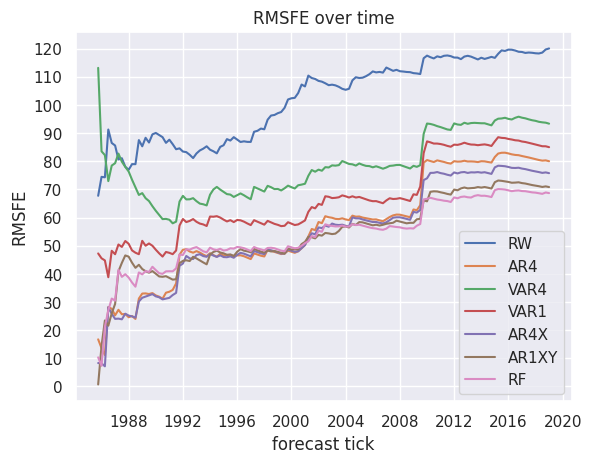

In [176]:
a = create_dataframe_models(forecasts, ['RW', 'AR4', 'VAR4', 'VAR1', 'AR4X', 'AR1XY', 'RF'])
b = rmsfe_over_time(a, ['RW', 'AR4', 'VAR4', 'VAR1', 'AR4X', 'AR1XY', 'RF'])
plt.show()


In [177]:
b[-1:]

,rmse_RW,rmse_AR4,rmse_VAR4,rmse_VAR1,rmse_AR4X,rmse_AR1XY,rmse_RF
133,120.059798,80.004779,93.345331,84.99347,75.766591,70.825912,68.679392
